# Directly optimize discrete IIR

In the notebook I try to apply the least squares to directly optimize the first 4 coefficients (a0, a1, b0, b1) of the IIR filter without using exponential approximation.

In [1]:
import numpy as np
import json
import pickle
import matplotlib.pyplot as plt

from pathlib import Path
from numpy import convolve
from scipy.signal import lfilter, lfilter_zi
from scipy.optimize import least_squares
from cryoscope_scripts import load_cryoscope_data
from IIR import (
    step,
    inverse_model_IIR,
    residuals_inverse_IIR,
    multi_exponential_IIR,
    residuals_multi_exponential,
    single_exp_params,
    iter_filter_application, 
    residuals_coefficients
)

from tools import (
    plot_signal_filtered,
    plot_reconstructed_data,
    plot_signal_filtered_iter,
    Signal,
)

from qibocal.protocols.two_qubit_interaction.cryoscope import _fit

FLUX_AMPLITUDE = 0.5
SAMPLING_RATE = 1
DIRECT = False
ITERATIONS = 5

[Qibo 0.2.12|INFO|2024-12-17 10:08:17]: Loading platform dummy
[Qibo 0.2.12|INFO|2024-12-17 10:08:17]: Loading platform dummy


In [2]:
data_path = (
    Path.cwd().parent / "cryo_material" / "long_acquisition" / "data" / "cryoscope-0"
)
data_json = data_path / "data.json"

with open(data_json, "rb") as file:
    data = json.load(file)

flux_pulse_amplitude = data['"flux_pulse_amplitude"']
cryoscope_data = load_cryoscope_data(data_path / "data.npz", FLUX_AMPLITUDE)

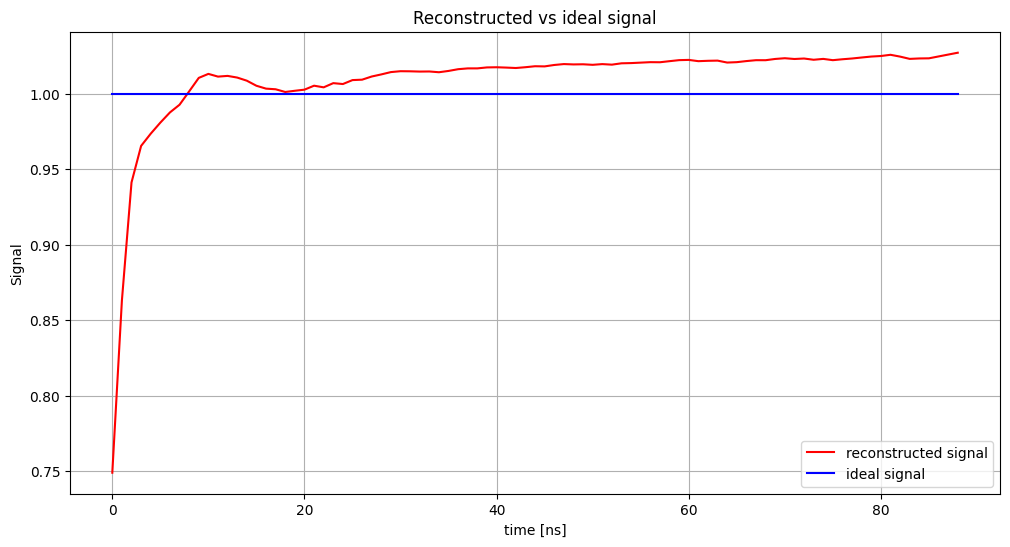

In [3]:
cryoscope_results = _fit(cryoscope_data)
t = np.arange(0,89,1)
start = 0 
#mi conscentro sul segnale semplicemente perchè è quello che poi dovremo correggere

plot_reconstructed_data(cryoscope_results, "D1", 10, t, start)

### Optimization using zi

In [4]:
initial_guess = [1,1,1,1]
step_response = cryoscope_results.step_response["D1"][10:]
result = least_squares(residuals_coefficients, initial_guess, args=(step_response, True, t, start))

with open("IIR_discrete_params.pkl", "wb") as pickle_file:
    pickle.dump(result, pickle_file)

In [5]:
print(result.x)

[ 0.54648102  0.02812436  1.225517   -0.65887566]


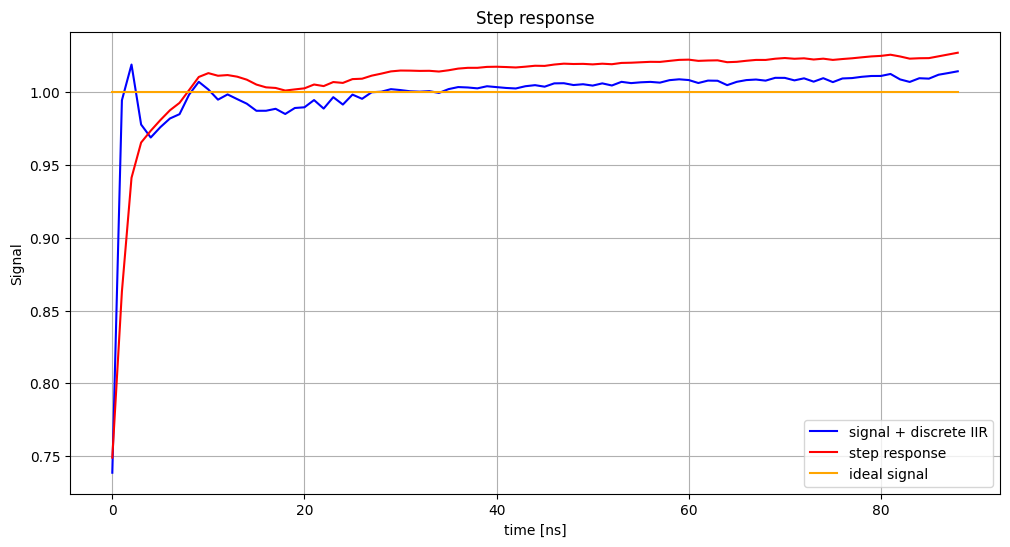

In [6]:
a0, a1, b0, b1 = result.x
a = np.array([a0, a1])
b = np.array([b0, b1])

zi = lfilter_zi(b, a) * step_response[0]
filtered, _ = lfilter(b, a, step_response, zi=zi)
filtered_response = Signal(signal=filtered, label="signal + discrete IIR")

response = Signal(step_response, label="step response")

plot_signal_filtered(filtered_response, response, t, start)

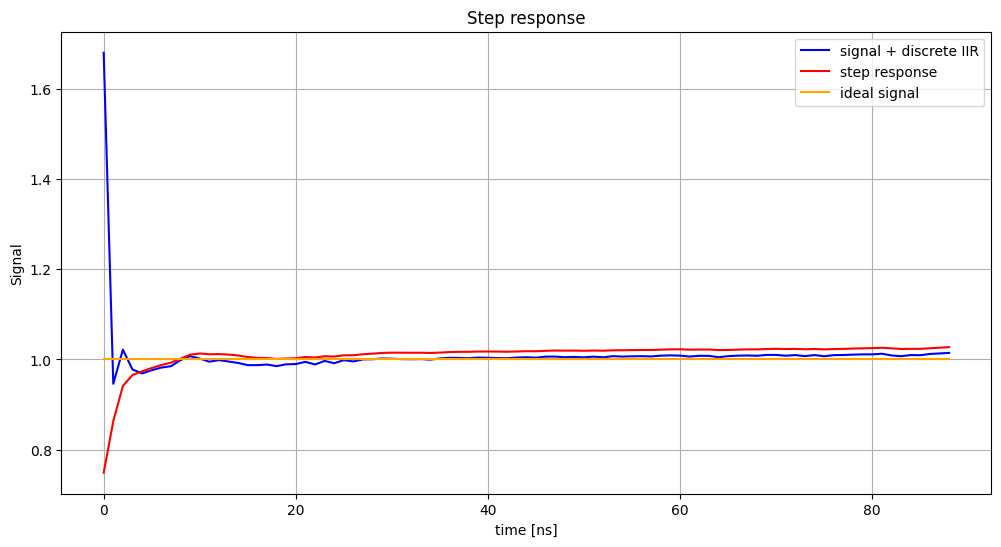

In [7]:
#plot without considering zi

filtered= lfilter(b, a, step_response)
filtered_response = Signal(signal=filtered, label="signal + discrete IIR")
response = Signal(step_response, label="step response")

plot_signal_filtered(filtered_response, response, t, start)

### Optimization without using zi

In [8]:
result = least_squares(
    residuals_coefficients, initial_guess, args=(step_response, False, t, start)
)

with open("IIR_discrete_params_no_zi.pkl", "wb") as pickle_file:
    pickle.dump(result, pickle_file)

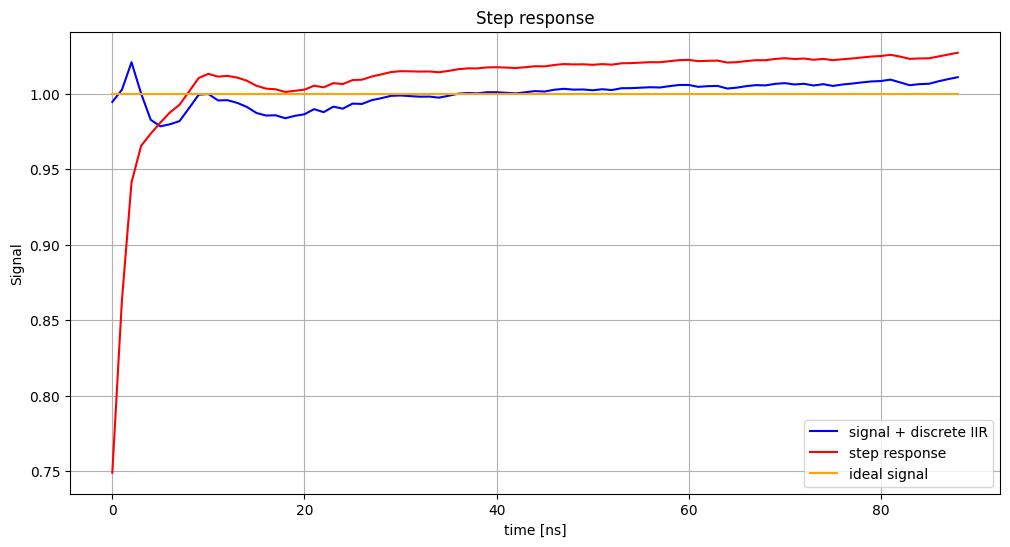

In [9]:
a0, a1, b0, b1 = result.x
a = np.array([a0, a1])
b = np.array([b0, b1])

filtered = lfilter(b, a, step_response)
filtered_response = Signal(signal=filtered, label="signal + discrete IIR")

response = Signal(step_response, label="step response")

plot_signal_filtered(filtered_response, response, t, start)